In [1]:
from tqdm import tqdm
import numpy as np
from PIL import Image
from math import log, sqrt, pi
import argparse
from torch import nn, optim
from torch.autograd import Variable, grad
from scipy import linalg as la
from transformers import CLIPProcessor, CLIPModel
import math
import torchvision.transforms as tvt
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wget
import zipfile
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as tfms
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision.utils import make_grid
from torchvision import utils
from PIL import Image
import random
from tqdm import trange
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import confusion_matrix
from wilds.datasets.fmow_dataset import FMoWDataset

torch.set_num_threads(5)   
torch.set_num_interop_threads(5)   

import open_clip


device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
batch_size = 1



model,_, preprocess =  open_clip.create_model_and_transforms("ViT-L-14", pretrained='laion2b_s32b_b82k') #ViTB/32
model = model.to(device)
tokenizer = open_clip.get_tokenizer('ViT-L-14')


root_dir =  '../../../Dataset/celeba/img_align_celeba/'
csv_file = '../../../Dataset/celeba/metadata.csv'
data_frame = pd.read_csv(csv_file)
data_frame.replace(-1, 0, inplace=True)

def seed_everything(seed):
    """
    Changes the seed for reproducibility. 
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    

    
class CustomDataset(Dataset):
    def __init__(self, csv_file, y, a, root_dir,split, transform):
        self.data_frame = csv_file
        self.data_frame = self.data_frame[self.data_frame['split'] == split].reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform
        self.targets = self.data_frame[y].values
        self.biases = self.data_frame[a].values
        self.i = list(range(self.targets.shape[0]))

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name)
        target = self.targets[idx]
        targets = torch.tensor(target) # assuming target is a class index
        sensitive = self.biases[idx]
        biases = torch.tensor(sensitive)
        img = preprocess(image)
            
        return img, targets, biases

target = 'Blond_Hair'
sensitive = 'Male'
    
transform = tfms.Compose([
        tfms.Resize((224,224)),
        tfms.ToTensor(),
        tfms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

train_set = CustomDataset(csv_file=data_frame, y = target, a= sensitive, root_dir=root_dir, split=0, transform=transform)
training_data_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_set = CustomDataset(csv_file=data_frame, y = target, a= sensitive, root_dir=root_dir, split=1, transform=transform)
valid_data_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_set = CustomDataset(csv_file=data_frame, y = target, a= sensitive, root_dir=root_dir, split=2, transform=transform)
test_data_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
print('Done')
data_frame

Done


,image_id,partition,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,split
0,000001.jpg,0,0,1,1,0,0,0,0,0,...,1,1,0,1,0,1,0,0,1,0
1,000002.jpg,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
2,000003.jpg,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
3,000004.jpg,0,0,0,1,0,0,0,0,0,...,0,1,0,1,0,1,1,0,1,0
4,000005.jpg,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202594,202595.jpg,2,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,2
202595,202596.jpg,2,0,0,0,0,0,1,1,0,...,1,1,0,0,0,0,0,0,1,2
202596,202597.jpg,2,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,2
202597,202598.jpg,2,0,1,1,0,0,0,1,0,...,1,0,1,1,0,1,0,0,1,2


Testing:   0%|                                                                       | 25/19962 [00:01<17:33, 18.92it/s]

<Figure size 1000x500 with 0 Axes>

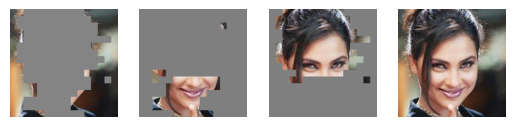

<Figure size 1000x500 with 0 Axes>

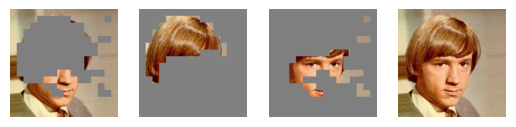

Testing:   0%|                                                                       | 27/19962 [00:01<25:53, 12.83it/s]

<Figure size 1000x500 with 0 Axes>

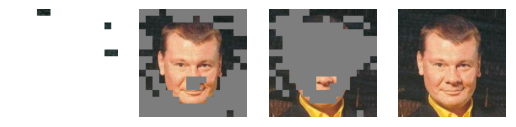

<Figure size 1000x500 with 0 Axes>

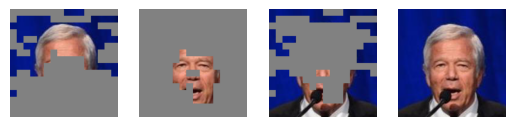

Testing:   0%|                                                                       | 29/19962 [00:02<30:21, 10.94it/s]

<Figure size 1000x500 with 0 Axes>

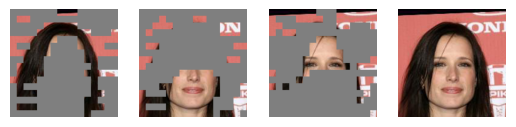

/home/jw-server3/a/lu876/miniconda3/envs/DLcourse/lib/python3.9/site-packages/torchvision/transforms/functional.py:282: RuntimeWarning: invalid value encountered in cast
  npimg = (npimg * 255).astype(np.uint8)


<Figure size 1000x500 with 0 Axes>

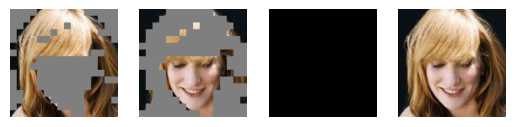

Testing: 100%|████████████████████████████████████████████████████████████████████| 19962/19962 [17:58<00:00, 18.51it/s]

Accuracy for y=0, s=0: 0.8348520528309614 9767.0
Accuracy for y=0, s=1: 0.86635700066357 7535.0
Accuracy for y=1, s=0: 0.9415322580645161 2480.0
Accuracy for y=1, s=1: 0.8333333333333334 180.0
Overall_Accuracy: 0.8599839695421301


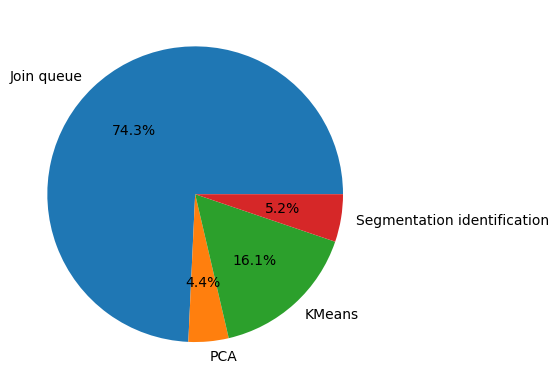

In [2]:
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import minmax_scale
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import gaussian_filter
from sklearn.cluster import AgglomerativeClustering
from collections import deque
import time


queue_length = 12

def pca_single_modality(pca_features, mask, n_imgs, img):  
    to_pil_image = tfms.ToPILImage()
    for i in range(3):
        pca_features[:, i] = (pca_features[:, i] - pca_features[:, i].min()) / (pca_features[:, i].max() - pca_features[:, i].min())
    plt.figure(figsize=(5, 5))
    
    for i in range(n_imgs):
        fig, ax = plt.subplots(1, 3)
        img[i] = (img[i] - img[i].min()) / (img[i].max() - img[i].min())
        image_np = to_pil_image(img[i].cpu().squeeze(0))
        ax[0].imshow(image_np)    
        print(pca_features[i*16*16 :(i+1)*16*16, :].shape)
        image_pca = torch.tensor(pca_features[i*16*16 :(i+1)*16*16, :].reshape(16,16, 3))                    
        ax[1].imshow(image_pca.cpu().numpy())
        ax[2].imshow(mask[i*16*16 :(i+1)*16*16, :].reshape(16,16, 3))
    plt.show()
    plt.close()



def pca_single_modality_queue(pca_features, mask, n_imgs, img, id, imshow = False):  
    to_pil_image = tfms.ToPILImage()
    for i in range(3):
        pca_features[:, i] = (pca_features[:, i] - pca_features[:, i].min()) / (pca_features[:, i].max() - pca_features[:, i].min())

    if id < queue_length:
        image_pca = torch.tensor(pca_features[id*16*16 : (id + 1)*16*16, :].reshape(16,16, 3))    
    else:
        image_pca = torch.tensor(pca_features[-16*16 :, :].reshape(16,16, 3))

    if id < queue_length:
        mask_tensor = mask[id*16*16 : (id + 1)*16*16, :].reshape(16,16, 3)
    else:
        mask_tensor = mask[-16*16 :, :].reshape(16,16, 3)
    
    if imshow == True:
        plt.figure(figsize=(5, 5))
        fig, ax = plt.subplots(1, 3)
        img = (img - img.min()) / (img.max() - img.min())
        image_np = to_pil_image(img.cpu().squeeze(0))
        ax[0].imshow(image_np)                 
        ax[1].imshow(image_pca.cpu().numpy())
        ax[2].imshow(mask_tensor)
        plt.show()
        plt.close()
    return mask_tensor


def masked_img(image, mask, imshow, prob):  # image: (3, 224, 224), mask: (16, 16, 3)
    to_pil_image = tfms.ToPILImage()
    mask_single_channel = torch.argmax(mask, dim=-1)  # Shape: [16, 16]
    mask_upsampled = F.interpolate(mask_single_channel.unsqueeze(0).unsqueeze(0).float(),
                                    size=(224, 224), mode="nearest").squeeze().long()  # Shape: [224, 224]
    binary_masks = [(mask_upsampled == value).float() for value in range(3)]
    masked_images = [image * binary_mask.unsqueeze(0) for binary_mask in binary_masks]
    normalized_images = []
    show_images = []
    for masked_image in masked_images:
        if masked_image.max() > masked_image.min():
            
            normalized_image = masked_image
        else:
            normalized_image = masked_image  # No normalization needed if uniform
        show_image = (masked_image - masked_image.min()) / (masked_image.max() - masked_image.min())
        normalized_images.append(normalized_image)
        show_images.append(show_image)
    if imshow == True:
        plt.figure(figsize=(10, 5))
        fig, ax = plt.subplots(1, 4)
        for i in range(3):
            image_np = to_pil_image(show_images[i].squeeze(0).cpu())
            ax[i].imshow(image_np)
            ax[i].axis('off')
            #ax[i].text(1, 0.5, f"prob {prob[i].item():.4f}", fontsize=10)
        img = (image - image.min()) / (image.max() - image.min())
        image_np_o = to_pil_image(img.cpu().squeeze(0))
        ax[3].imshow(image_np_o) 
        ax[3].axis('off')
        plt.show()
    return normalized_images
    

def my_convert_ids_to_tokens(tokenizer, token_ids):
    if isinstance(token_ids, torch.Tensor):
        token_ids = token_ids.tolist()
    
    tokens = []
    for tid in token_ids:
        if tid in tokenizer.decoder:
            tokens.append(tokenizer.decoder[tid])
        else:
            tokens.append(f"[UNK_{tid}]")
    return tokens


def fast_PCA(X):
    X = X.to(device)
    U, S, Vt = torch.svd_lowrank(X, q=3)
    k = 3
    PCs = Vt[:, :k]
    X_pca = X @ PCs 
    return X_pca
    

def test_epoch(vlm,   dataloader):  
    vlm = vlm.to(device)
    vlm.eval()   
    visual = vlm.visual
    img_show = 31
    vlm.visual.pool_type = None
    vlm.text_pool_type = 'last'
    T =1
    texts_label = ["a photo of a celebrity with dark hair.", "a photo of a celebrity with blonde hair."] 
    general_label = ["A photo of visible hair."]
    text_label_tokened = tokenizer(texts_label).to(device)
    general_label_tokened = tokenizer(general_label).to(device)
    text_embeddings = vlm.encode_text(text_label_tokened)
    vlm.text_pool_type = 'first'
    general_embeddings = vlm.encode_text(general_label_tokened)
    iteration = 0
    queue = deque()
    pca = PCA(n_components=3)
    correct_00, total_00 = 0, 0
    correct_01, total_01 = 0, 0
    correct_10, total_10 = 0, 0
    correct_11, total_11 = 0, 0
    segment_num = 3
    
    for _, (sample, _, _) in enumerate(tqdm(dataloader, desc="Testing")):
        sample = sample.to(device)
        img_embeds = vlm.encode_image(sample)[:,1:,:].squeeze(0)  #torch.Size([1, 257, 768])
        img_embeds = img_embeds.detach().cpu().numpy()   
        queue.append(img_embeds)
        iteration += 1
        if iteration> queue_length:
            break
            
    iteration = 0
    time_1 = 0
    time_2 = 0
    time_3 = 0
    time_4 = 0
    for step, (test_input, test_target, sensitive_real) in enumerate(tqdm(dataloader, desc="Testing")):
        with torch.no_grad(): 
            start_step1 = time.time()
            gt = test_target.detach().cpu().numpy()
            sen = sensitive_real.detach().cpu().numpy()      
            test_input = test_input.to(device)
            img_embeddings = vlm.encode_image(test_input)  #torch.Size([1, 257, 768])
            comb_feature_gpu = img_embeddings[:,1:,:].squeeze(0)
            comb_feature = comb_feature_gpu.detach().cpu().numpy() 
            
            if step < queue_length:
                combined_array = torch.vstack([torch.from_numpy(arr) if isinstance(arr, np.ndarray) else arr for arr in queue]).to(device)

                
            else:            
                queue.popleft()
                queue.append(comb_feature)
                combined_array = torch.vstack([torch.from_numpy(arr) if isinstance(arr, np.ndarray) else arr for arr in queue]).to(device)


            end_step1 = time.time()
            lapse = end_step1 - start_step1
            time_1+= lapse
            start_step2 = time.time()
            pca_features = fast_PCA(combined_array).cpu().numpy()
            end_step2 = time.time()
            lapse_2 = end_step2 - start_step2
            time_2+= lapse_2

            start_step3 = time.time()
            smoothed_data = gaussian_filter(pca_features, sigma=(0.85, 0))
            kmean_cluster = KMeans(n_clusters=segment_num, random_state=0, n_init="auto").fit_predict(smoothed_data)
            encoder = OneHotEncoder(sparse_output=False)
            one_hot_mask = encoder.fit_transform(kmean_cluster.reshape(-1, 1))
            pca_features_rgb = pca_features.copy()

            end_step3 = time.time()
            lapse_3 = end_step3 - start_step3
            time_3+= lapse_3

            start_step4 = time.time()
            mask = pca_single_modality_queue(pca_features_rgb, one_hot_mask, batch_size, test_input, step)
            msks = masked_img(test_input.cpu(), torch.tensor(mask).cpu(), False, None)
            mask_single_channel = torch.argmax(torch.tensor(mask).cpu(), dim=-1).view(16, 16).contiguous().view(-1)
            local_rep = [comb_feature_gpu[mask_single_channel==i] for i in range(segment_num)]
            seg_embedding = torch.vstack([torch.mean(local_rep[i], dim=0, keepdim = True) for i in range(segment_num)])
            if torch.isnan(seg_embedding).any():
                # Mask out NaNs
                valid_values = seg_embedding[~torch.isnan(seg_embedding)]
                if valid_values.numel() > 0:  
                    max_value = torch.max(valid_values)
                    seg_embedding = torch.where(torch.isnan(seg_embedding), max_value, seg_embedding)

            seg_embedding = seg_embedding/seg_embedding.norm(dim=1, keepdim=True)
            general_embeddings = general_embeddings / general_embeddings.norm(dim=1, keepdim=True)
            seg_cosine_similarity = torch.mm(seg_embedding, general_embeddings.t())
            probs = seg_cosine_similarity.softmax(dim = 0)
            conf, predic = torch.max(probs.data, 0)
            end_step4 = time.time()
            lapse_4 = end_step4 - start_step4
            time_4+= lapse_4
            
            if step < img_show and step>queue_length*2:
                masked_img(test_input.cpu(), torch.tensor(mask).cpu(), True, probs)            
            
            high_attention_seg = msks[predic]
            high_embedding = vlm.encode_image(high_attention_seg.to(device))[:,0,:] 
            high_embedding = high_embedding.squeeze(1)
            high_embedding = high_embedding/high_embedding.norm(dim=1, keepdim=True)
            text_embeddings = text_embeddings/text_embeddings.norm(dim=1, keepdim=True)

            cosine_similarity = torch.mm(high_embedding, text_embeddings.t())
            logits_per_image = cosine_similarity 
            probs = logits_per_image.softmax(dim=1)
            _, predic = torch.max(probs.data, 1)
            predic = predic.detach().cpu()

            label = test_target.detach().cpu()
            mask_00 = ((label == 0) & (sensitive_real == 0))
            mask_01 = ((label == 0) & (sensitive_real == 1))
            mask_10 = ((label == 1) & (sensitive_real == 0))
            mask_11 = ((label == 1) & (sensitive_real == 1))


            correct_00 += (predic[mask_00] == label[mask_00]).float().sum().item()
            total_00 += mask_00.float().sum().item()
            correct_01 += (predic[mask_01] == label[mask_01]).float().sum().item()
            total_01 += mask_01.float().sum().item()
            correct_10 += (predic[mask_10] == label[mask_10]).float().sum().item()
            total_10 += mask_10.float().sum().item()
            correct_11 += (predic[mask_11] == label[mask_11]).float().sum().item()
            total_11 += mask_11.float().sum().item() 

                
    acc_00 = correct_00 / total_00
    acc_01 = correct_01 / total_01
    acc_10 = correct_10 / total_10
    acc_11 = correct_11 / total_11
    acc = (correct_00 + correct_01 + correct_10 + correct_11) / (total_00 + total_01 + total_10 + total_11)

    print(f'Accuracy for y=0, s=0: {acc_00}', total_00)
    print(f'Accuracy for y=0, s=1: {acc_01}', total_01)
    print(f'Accuracy for y=1, s=0: {acc_10}', total_10)
    print(f'Accuracy for y=1, s=1: {acc_11}', total_11)  
    print(f'Overall_Accuracy: {acc}')


    labels = ['Join queue', 'PCA', 'KMeans', 'Segmentation identification']
    durations = [time_1, time_2, time_3,time_4]
    plt.pie(durations, labels=labels, autopct='%1.1f%%')
    plt.show()
    
            


seed_everything(2048)  
model = model.to(device)
model = model.eval()
test_epoch(model, test_data_loader)